In [1]:
import numpy as np
import os
import sys
import copy
import math
import csv

import torch
import random

import sys
sys.path.append('./backbones/asrf')
from libs import models
from libs.optimizer import get_optimizer
from libs.dataset import ActionSegmentationDataset, collate_fn
from libs.transformer import TempDownSamp, ToTensor
from libs.postprocess import PostProcessor

sys.path.append('./backbones/ms-tcn')
from model import MultiStageModel

sys.path.append('./backbones')
sys.path.append('./backbones/SSTDA')
from SSTDA.model import MultiStageModel as MSM_SSTDA

from src.utils import eval_txts, load_meta
from src.predict import predict_refiner
from src.refiner_train import refiner_train
from src.refiner_model import RefinerModel
from src.mgru import mGRU

import configs.refiner_config as cfg
import configs.sstda_config as sstda_cfg
import configs.asrf_config as asrf_cfg

import matplotlib.pyplot as plt


In [2]:
dataset_names = ['gtea', '50salads', 'breakfast']
backbone_names = ['asrf', 'mstcn', 'sstda', 'mgru']
num_splits = dict()
num_splits['gtea'] = 4
num_splits['50salads']=5
num_splits['breakfast']=4

In [3]:
curr_refiner = 'refinerMSTCN-mstcn'
curr_backbone = 'mstcn'
dataset = 'gtea'
split = 4

In [5]:
record_root = './record'
refiner_best_epoch = dict()

for dir_name in sorted([x for x in os.listdir(record_root) if x[0]!='.']):
    backbone_name = ''.join([t for t in dir_name if t.isupper()]).lower()
    if len(backbone_name) > 0:
        refiner_best_epoch[dir_name] = {dn:[] for dn in dataset_names}
                
        for data_name in os.listdir(os.path.join(record_root, dir_name)):
            csv_list = os.listdir(os.path.join(record_root, dir_name, data_name))
            plot_flag = True
            for i in range(num_splits[data_name]):
                if 'split_{}_best.csv'.format(i+1) not in csv_list:
                    plot_flag = False
            if plot_flag:
                curr_score = np.asarray([0.0 for _ in range(5)])
                backbone_score = np.asarray([0.0 for _ in range(5)])
                for i in range(num_splits[data_name]):
                    curr_csv_fp = os.path.join(record_root, dir_name, data_name, 'split_{}_best.csv'.format(i+1))
                    backbone_csv_fp = os.path.join(record_root, backbone_name, data_name, 'split_{}_best.csv'.format(i+1))
                    with open(curr_csv_fp, 'r') as f:
                        reader = csv.reader(f, delimiter='\t')
                        for ri, row in enumerate(reader):
                            if ri>0:
                                refiner_best_epoch[dir_name][data_name].append(int(row[0]))
                                curr_score += np.asarray([float(r) for r in row[1:]]) / num_splits[data_name]


In [6]:
device = 'cuda'

In [7]:
actions_dict, \
num_actions, \
gt_path, \
features_path, \
vid_list_file, \
vid_list_file_tst, \
sample_rate,\
model_dir,\
result_dir, \
record_dir = load_meta(cfg.dataset_root, cfg.model_root, cfg.result_root, cfg.record_root, 
                       dataset, split, curr_refiner)

Created :./model/refinerMSTCN-mstcn/gtea/split_1
Created :./result/refinerMSTCN-mstcn/gtea/split_1
Created :./record/refinerMSTCN-mstcn/gtea


In [8]:
curr_split_dir = os.path.join(cfg.dataset_root, dataset, 'splits')
split_dict = {k+1:[] for k in range(cfg.num_splits[dataset])}
for i in range(eval('cfg.num_splits["{}"]'.format(dataset))):
    curr_fp = os.path.join(curr_split_dir, 'test.split{}.bundle'.format(i+1))
    f = open(curr_fp, 'r')
    lines = f.readlines()
    for l in lines:
        curr_name = l.split('.')[0]
        split_dict[i+1].append(curr_name)
    f.close()

In [9]:
pool_backbones = {bn: {k+1:None for k in range(cfg.num_splits[dataset])} for bn in cfg.backbone_names}

for i in range(eval('cfg.num_splits["{}"]'.format(dataset))):
    if 'asrf' in cfg.backbone_names:
        curr_asrf = models.ActionSegmentRefinementFramework(
                        in_channel = cfg.in_channel,
                        n_features = cfg.n_features,
                        n_classes = num_actions,
                        n_stages = cfg.n_stages,
                        n_layers = cfg.n_layers,
                        n_stages_asb = cfg.n_stages_asb,
                        n_stages_brb = cfg.n_stages_brb
        )
        curr_asrf.load_state_dict(torch.load(os.path.join(cfg.model_root, 'asrf', dataset, 
                                                          'split_{}'.format(i+1), 
                                                          'epoch-{}.model'.format(cfg.best['asrf'][dataset][i]))))
        curr_asrf.to(device)
        pool_backbones['asrf'][i+1] = curr_asrf
        
    if 'mstcn' in cfg.backbone_names:
        curr_mstcn = MultiStageModel(cfg.num_stages,
                                     num_layers = cfg.num_layers,
                                     num_f_maps = cfg.num_f_maps,
                                     dim = cfg.features_dim,
                                     num_classes = num_actions)
        curr_mstcn.load_state_dict(torch.load(os.path.join(cfg.model_root, 'mstcn', dataset,
                                                          'split_{}'.format(i+1),
                                                          'epoch-{}.model'.format(cfg.best['mstcn'][dataset][i]))))
        curr_mstcn.to(device)
        pool_backbones['mstcn'][i+1] = curr_mstcn
        
    if 'sstda' in cfg.backbone_names:
        curr_sstda = MSM_SSTDA(sstda_cfg, num_actions)
        curr_sstda.load_state_dict(torch.load(os.path.join(cfg.model_root, 'sstda', dataset,
                                                          'split_{}'.format(i+1),
                                                          'epoch-{}.model'.format(cfg.best['sstda'][dataset][i]))))
        curr_sstda.to(device)
        pool_backbones['sstda'][i+1] = curr_sstda
        
    if 'mgru' in cfg.backbone_names:
        curr_mgru = mGRU(num_layers=cfg.gru_layers, 
                         feat_dim=cfg.gru_hidden_dim, 
                         inp_dim=cfg.in_channel, 
                         out_dim=num_actions)
        curr_mgru.load_state_dict(torch.load(os.path.join(cfg.model_root, 'mgru', dataset,
                                                          'split_{}'.format(i+1),
                                                          'epoch-{}.model'.format(cfg.best['mgru'][dataset][i]))))
        curr_mgru.to(device)
        pool_backbones['mgru'][i+1] = curr_mgru
        
main_backbones = copy.deepcopy(pool_backbones[curr_backbone])

In [10]:
model = RefinerModel(num_actions = num_actions,
                    input_dim = cfg.features_dim,
                    feat_dim = cfg.hidden_dim,
                    num_highlevel_frames = cfg.num_highlevel_frames,
                    num_highlevel_samples = cfg.num_highlevel_samples,
                    device = device)
model.load_state_dict(torch.load(os.path.join(cfg.model_root, curr_refiner, 
                                              dataset, 'split_{}'.format(split), 
                                              'epoch-{}.model'.format(refiner_best_epoch[curr_refiner][dataset][split-1]))))
model.to(device)


RefinerModel(
  (key_embedding): Linear(in_features=2048, out_features=512, bias=False)
  (value_embedding): Linear(in_features=2048, out_features=512, bias=False)
  (query_embedding): Embedding(11, 512)
  (label_embedding): Embedding(11, 512)
  (video_embedding): SparseSampleEmbedder(
    (init_conv): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (blocks): ModuleList(
      (0): ResidualBlock(
        (block): Sequential(
          (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): LeakyReLU(negative_slope=0.1)
          (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): LeakyReLU(negative_slope=0.1)
          (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (2): ResidualBlock(
        (block): Sequential(
        

In [11]:
def get_segment_idx(segment_res):
    segment_time = [0]
    segment_ind = [segment_res[0]]
    for i, s in enumerate(segment_res):
        if s != segment_ind[-1]:
            segment_time.append(i)
            segment_ind.append(s)
    segment_time.append(len(segment_res))

    return segment_time, segment_ind

def get_name(ind_list, actions_dict):
    name_list = []
    for ind in ind_list:
        name_list += [key for key in actions_dict if actions_dict[key]==ind]
    return name_list

def color_map(N=256, normalized=True):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    dtype = 'float32' if normalized else 'uint8'
    cmap = np.zeros((N, 3), dtype=dtype)
    for i in range(N):
        r = g = b = 0
        c = i
        for j in range(8):
            r = r | (bitget(c, 0) << 7-j)
            g = g | (bitget(c, 1) << 7-j)
            b = b | (bitget(c, 2) << 7-j)
            c = c >> 3

        cmap[i] = np.array([r, g, b])

    cmap = cmap/255 if normalized else cmap
    return cmap
N = len(actions_dict)
RGB_tuples = color_map(100)
print(N)

11


In [12]:
def plot_prediction(model, main_backbone_name, backbones, split_dict, model_dir, result_dir, gt_path, features_path, vid_list_file, actions_dict, device, sample_rate):
    model.eval()
    with torch.no_grad():
        file_ptr = open(vid_list_file, 'r')
        list_of_vids = file_ptr.read().split('\n')[:-1]
        file_ptr.close()
        
        total_seg = 0
        total_wrong = 0
        for vid in list_of_vids:
            print(vid)
            f = open(os.path.join(gt_path, vid), 'r')
            lines = f.readlines()
            gt_segment = []
            for l in lines:
                gt_segment.append(actions_dict[l[:-1]])

            features = np.load(features_path + vid.split('.')[0] + '.npy')
            features = features[:, ::sample_rate]
            input_x = torch.tensor(features, dtype=torch.float)
            input_x.unsqueeze_(0)
            input_x = input_x.to(device)
            
            split_idx = 0
            for i in range(len(split_dict.keys())):
                if vid.split('.')[0] in split_dict[i+1]:
                    split_idx = i+1
                    break
            
            curr_backbone = backbones[split_idx]
            curr_backbone.eval()
            
            if main_backbone_name != 'asrf':
                if main_backbone_name == 'mstcn':
                    mask = torch.ones(input_x.size(), device=device)
                    action_pred = curr_backbone(input_x, mask)[-1]
                elif main_backbone_name == 'mgru':
                    action_pred = curr_backbone(input_x)
                elif main_backbone_name == 'sstda':
                    mask = torch.ones(input_x.size(), device=device)
                    action_pred, _, _, _, _, _, _, _, _, _, _, _, _, _ = curr_backbone(input_x, 
                                                                                       input_x, 
                                                                                       mask, 
                                                                                       mask, 
                                                                                       [0, 0], 
                                                                                       reverse=False)
                    action_pred = action_pred[:, -1, :, :]

                action_idx = torch.argmax(action_pred, dim=1).squeeze().detach()
                
            else:
                out_cls, out_bound = curr_backbone(input_x)
                postprocessor = PostProcessor("refinement_with_boundary", asrf_cfg.boundary_th)
                refined_output_cls = postprocessor(out_cls.cpu().data.numpy(), boundaries=out_bound.cpu().data.numpy(), 
                                                   masks=torch.ones(1, 1, input_x.shape[-1]).bool().data.numpy())
                action_idx = torch.Tensor(refined_output_cls).squeeze().detach()

            _, predictions, _ = model(action_idx.to(device), input_x)
            _, predicted = torch.max(predictions.data, 1)
                
            predicted = predicted.squeeze()
            
            backbone_time, backbone_ind = get_segment_idx(action_idx)
            backbone_ind = [int(x.item()) for x in backbone_ind]
            refine_time, refine_ind = get_segment_idx(predicted)
            refine_ind = [x.item() for x in refine_ind]
            gt_time, gt_ind = get_segment_idx(gt_segment)

            plt.figure(figsize=(15, 5))
            plt.axis('off')
            thres = 1000000
            for i, t in enumerate(gt_time[:-1]):
                if t < thres*sample_rate:
                    plt.plot([t/sample_rate, gt_time[i+1]/sample_rate], [4, 4], linewidth=30, color=RGB_tuples[gt_ind[i]])

            for i, t in enumerate(backbone_time[:-1]):
                if t < thres:
                    plt.plot([t, backbone_time[i+1]], [2, 2], linewidth=30, color=RGB_tuples[backbone_ind[i]])

            for i, t in enumerate(refine_time[:-1]):
                if t < thres:
                    plt.plot([t, refine_time[i+1]], [0, 0], linewidth=30, color=RGB_tuples[refine_ind[i]])
    
            plt.pause(0.1)    
            
            gt_name = get_name(gt_ind, actions_dict)
            bb_name = get_name(backbone_ind, actions_dict)
            refine_name = get_name(refine_ind, actions_dict)
        
            
            print(gt_name)
            print(bb_name)
            print(refine_name)
            print('='*80)


S1_Cheese_C1.txt


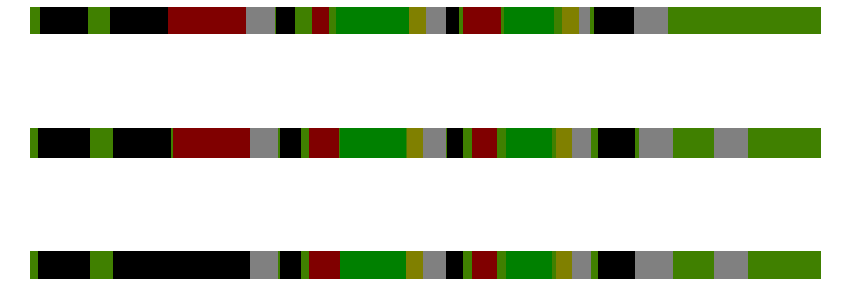

['background', 'take', 'background', 'take', 'open', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'close', 'put', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'put', 'background']
['background', 'take', 'background', 'take', 'background', 'open', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'put', 'background', 'put', 'background']
['background', 'take', 'background', 'take', 'put', 'background', 'take', 'background', 'open', 'pour', 'close', 'put', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'put', 'background', 'put', 'background']
S1_CofHoney_C1.txt


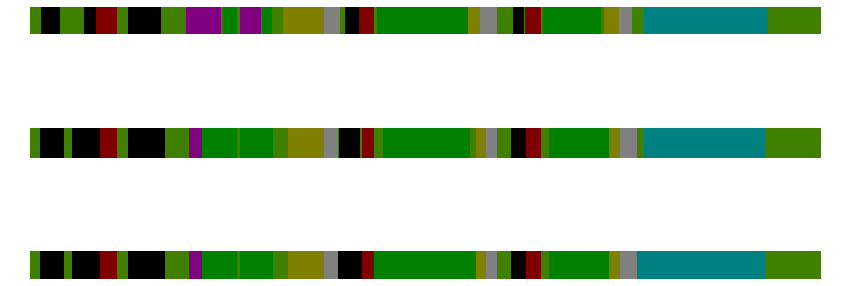

['background', 'take', 'background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'background', 'pour', 'background', 'scoop', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'pour', 'close', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'pour', 'close', 'put', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'background', 'pour', 'background', 'close', 'put', 'take', 'open', 'pour', 'close', 'put', 'background', 'take', 'open', 'background', 'pour

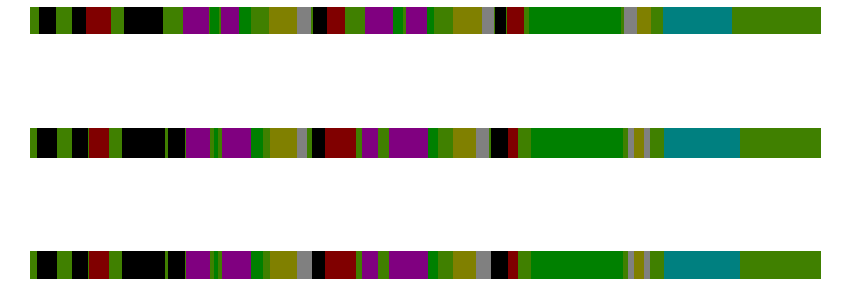

['background', 'take', 'background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'background', 'pour', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'scoop', 'pour', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'put', 'close', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'background', 'open', 'background', 'take', 'background', 'take', 'background', 'scoop', 'background', 'pour', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'scoop', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'pour', 'background', 'close', 'put', 'close', 'put', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'background', 'open', 'background', 'take', 'background

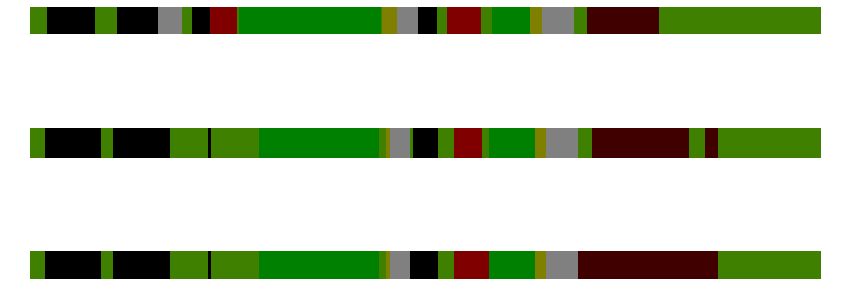

['background', 'take', 'background', 'take', 'put', 'background', 'take', 'open', 'background', 'pour', 'background', 'close', 'put', 'take', 'background', 'open', 'background', 'pour', 'close', 'put', 'background', 'fold', 'background']
['background', 'take', 'background', 'take', 'background', 'take', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'open', 'background', 'pour', 'close', 'put', 'background', 'fold', 'background', 'fold', 'background']
['background', 'take', 'background', 'take', 'background', 'take', 'background', 'pour', 'background', 'close', 'put', 'take', 'background', 'open', 'pour', 'close', 'put', 'fold', 'background']
S1_Pealate_C1.txt


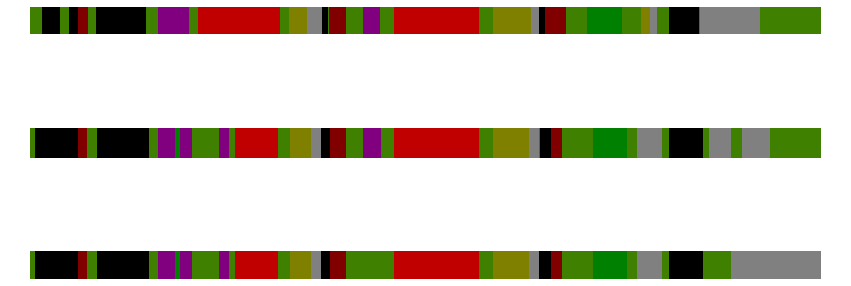

['background', 'take', 'background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'background', 'spread', 'background', 'close', 'put', 'take', 'background', 'open', 'background', 'scoop', 'background', 'spread', 'background', 'close', 'put', 'take', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'put', 'background']
['background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'scoop', 'background', 'scoop', 'background', 'spread', 'background', 'close', 'put', 'take', 'open', 'background', 'scoop', 'background', 'spread', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'pour', 'background', 'put', 'background', 'take', 'background', 'put', 'background', 'put', 'background']
['background', 'take', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'scoop', 'background', 'scoop', 'background', 'spread', 'background', 'close', 'put', 'take', 'open', 'background', 's

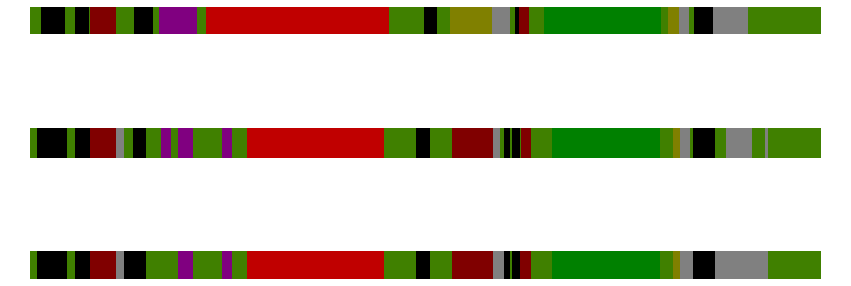

['background', 'take', 'background', 'take', 'background', 'open', 'background', 'take', 'background', 'scoop', 'background', 'spread', 'background', 'take', 'background', 'close', 'put', 'background', 'take', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'put', 'background']
['background', 'take', 'background', 'take', 'open', 'put', 'background', 'take', 'background', 'scoop', 'background', 'scoop', 'background', 'scoop', 'background', 'spread', 'background', 'take', 'background', 'open', 'put', 'background', 'take', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'put', 'background', 'put', 'background']
['background', 'take', 'background', 'take', 'open', 'put', 'take', 'background', 'scoop', 'background', 'scoop', 'background', 'spread', 'background', 'take', 'background', 'open', 'put', 'take', 'background', 'take', 'open', 'background', 'pour', 'background', 'c

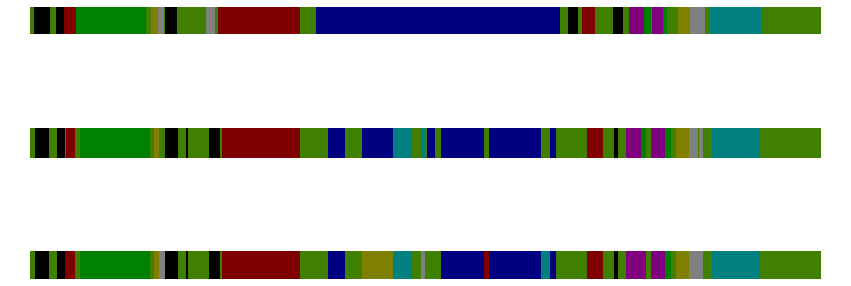

['background', 'take', 'background', 'take', 'open', 'pour', 'background', 'close', 'put', 'background', 'take', 'background', 'put', 'background', 'open', 'background', 'shake', 'background', 'take', 'background', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'background', 'open', 'background', 'pour', 'background', 'close', 'background', 'take', 'background', 'take', 'background', 'take', 'background', 'open', 'background', 'shake', 'background', 'shake', 'stir', 'background', 'stir', 'background', 'shake', 'background', 'shake', 'background', 'shake', 'background', 'shake', 'background', 'open', 'background', 'take', 'background', 'scoop', 'pour', 'background', 'scoop', 'pour', 'background', 'close', 'put', 'background', 'put', 'background', 'stir', 'background']
['background', 'take', 'background', 'take', 'open', 'background',

In [13]:
plot_prediction(model, curr_backbone, main_backbones, 
                split_dict, model_dir, result_dir, gt_path, features_path, 
                vid_list_file_tst, actions_dict, device, sample_rate)

#### 